In [7]:
from sklearn.decomposition import PCA

In [8]:
# Initial code provided by Veena Suresh for the LSTM model
# This code for the BiLSTM model with additional outcome metrics

from datetime import datetime 
import os
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Define the path to the dataset
dataset_path = 'D:\Feature Engineering\Room2_npy'

# Define the target length for data trimming/padding
target_length = 750

# Define parameters for model
Model_type = "Bidirectional Long Short-Term Memory"
batchsize = 32
monitor_choice = 'val_loss'
dropout = 0.3
learningrate = 0.001

#Initialise lists
data_list = []
data_list1 = []
labels_list = []

classes_to_double = ["kneel", "liedown", "pickup"]

# Helper function to split sequences

def split_sequence(sequence, step):
    return [sequence[i:i + step] for i in range(0, len(sequence), step) if len(sequence[i:i + step]) == step]

# Traverse through each activity directory
for activity_folder in os.listdir(dataset_path):
    activity_path = os.path.join(dataset_path, activity_folder)
##    print(f"Processing activity: {activity_folder}")

    if os.path.isdir(activity_path):
        for participant_file in os.listdir(activity_path):
            participant_path = os.path.join(activity_path, participant_file)
            if os.path.isfile(participant_path) and participant_file.endswith('.npy'):
##                print(f"Loading data from file: {participant_file}")
                data = np.load(participant_path)
                data = np.real(data)

                # Split data into smaller sequences
                data_splits = split_sequence(data, target_length)

                for split_data in data_splits:
                    # Normalize data
#                     min_val = np.min(split_data)
#                     max_val = np.max(split_data)
                   ##  Z-Score normalization
                    mean = np.mean(split_data, axis=0)
                    std = np.std(split_data, axis=0)
                    data_normalized = (split_data - mean) / (std + 1e-8) 

                    label = activity_folder
#                    data_list1.append(data_normalized[:, 0:30])          
#                    labels_list.append(label)
#                    data_list1.append(data_normalized[:, 30:60])          
#                    labels_list.append(label)
                    data_list.append(data_normalized)          
                    labels_list.append(label)
                    if label in classes_to_double:
                        data_list.append(data_normalized.copy())  # Double the data
                        labels_list.append(label)  # Double the label

# Convert lists to arrays for machine learning processing
data = np.array(data_list)
labels = np.array(labels_list).reshape(-1, 1)

print("Final data shape:", data.shape)
print("Final labels shape:", labels.shape)

Final data shape: (1814, 750, 90)
Final labels shape: (1814, 1)


In [9]:
## Reshaping the data and applying PCA
original_shape = data.shape 
data_reshaped = data.reshape(-1, original_shape[2])
pca = PCA(n_components=50)
data_pca_flat = pca.fit_transform(data_reshaped) 
data_pca = data_pca_flat.reshape(original_shape[0], original_shape[1], -1)
print("New shape after PCA:", data_pca.shape)

New shape after PCA: (1814, 750, 50)


In [11]:
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, BatchNormalization, Attention, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

# BiLSTM layer
bilstm_out = Bidirectional(LSTM(128, return_sequences=True), merge_mode='sum')(inputs)
drop1 = Dropout(0.3)(bilstm_out)
norm1 = BatchNormalization()(drop1)

# Self-Attention
attn_out = Attention()([norm1, norm1])
attn_mean = GlobalAveragePooling1D()(attn_out)

# Dense layers
dense1 = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(attn_mean)
drop2 = Dropout(0.3)(dense1)
outputs = Dense(y_train_encoded.shape[1], activation='softmax')(drop2)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=learningrate), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 750, 50)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 750, 128)  │    183,296 │ input_layer_3[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 750, 128)  │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 750, 128)  │        512 │ dropout_1[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 750, 128)  │          0 │ batch_normalizat… │
│ (Attention)         │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ attention_1[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 8)         │        520 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 192,584 (752.28 KB)

 Trainable params: 192,328 (751.28 KB)

 Non-trainable params: 256 (1.00 KB)

In [12]:
# Implement early stopping
monitor_choice = 'val_loss'
patience_number = 20
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

epochsvalue = 100

# start the timer for model training
start_time = datetime.now() 

# Train the model
history = model.fit(X_train, y_train_encoded, epochs=epochsvalue, batch_size=32, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping])

# Get the final training accuracy and loss
train_loss = history.history['loss'][-1]
train_accuracy = history.history['accuracy'][-1]
print(f"Final training loss: {train_loss:.4f}")
print(f"Final training accuracy: {train_accuracy:.4f}")

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

#End timing and calculate total time for training
end_time = datetime.now() 
time_difference = (end_time - start_time).total_seconds()/60


Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 401ms/step - accuracy: 0.4547 - loss: 1.6552 - val_accuracy: 0.7521 - val_loss: 1.2857
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 389ms/step - accuracy: 0.7792 - loss: 0.7723 - val_accuracy: 0.8567 - val_loss: 0.7375
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 407ms/step - accuracy: 0.8672 - loss: 0.5223 - val_accuracy: 0.8733 - val_loss: 0.5148
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 476ms/step - accuracy: 0.8978 - loss: 0.4040 - val_accuracy: 0.9311 - val_loss: 0.3028
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 415ms/step - accuracy: 0.9256 - loss: 0.2968 - val_accuracy: 0.9366 - val_loss: 0.2605
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 439ms/step - accuracy: 0.9487 - loss: 0.2537 - val_accuracy: 0.9339 - val_loss: 0.2412
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 420ms/step - accuracy: 0.9490 - loss: 0.2315 - val_accuracy: 0.9559 - val_loss: 0.2045
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 417ms/step - accuracy: 0.9658 - loss: 0.1957 - 

In [15]:
# Save the model using the native Keras format
model.save('bilstm_model.keras')

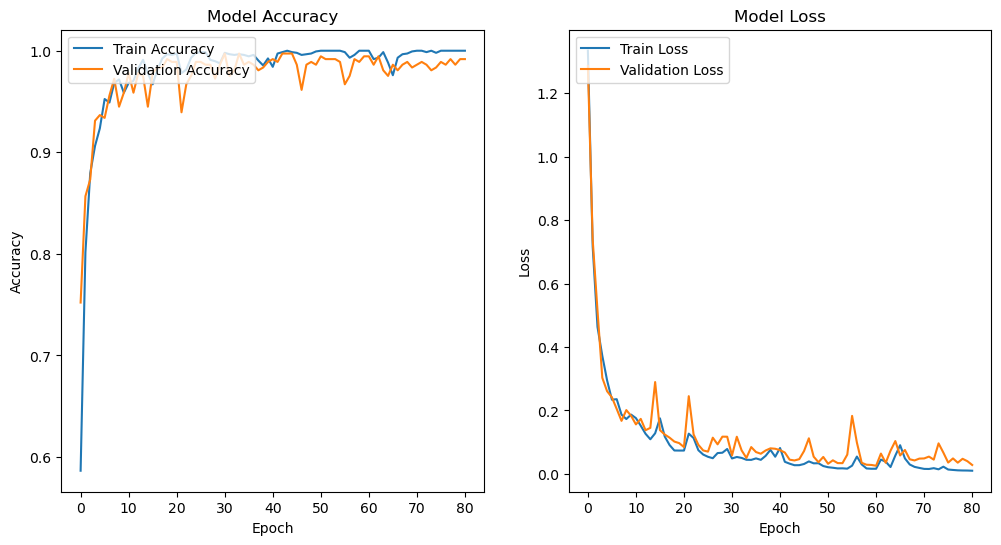

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step

Model outcomes

Model type:  Bidirectional Long Short-Term Memory

Execution time of program is: 25.2 minutes

Test loss:       0.0256
Test accuracy:   0.9945
Target Length:   750
Batch Size:      32
Early Stopping:  val_loss
Patience:        20
Dropout:         0.3
Learning Rate:   0.001

              precision    recall  f1-score   support

       Kneel       1.00      1.00      1.00        46
    Lie Down       0.98      1.00      0.99        60
     Pick Up       1.00      0.98      0.99        48
         Sit       1.00      0.98      0.99        50
  Sit Rotate       1.00      1.00      1.00        42
       Stand       0.98      1.00      0.99        51
Stand Rotate       1.00      1.00      1.00        42
        Walk       1.00      1.00      1.00        24

    accuracy                           0.99       363
   macro avg       1.00      0.99      1.00       363
weighted avg       0.99      0.99      0.99       363



<Figure size 1200x800 with 0 Axes>

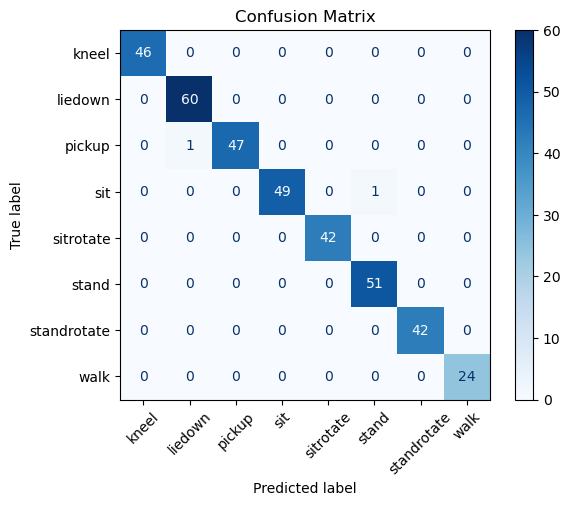

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Make predictions
y_pred_encoded = model.predict(X_test)
y_pred = np.argmax(y_pred_encoded, axis=1)
y_true = np.argmax(y_test_encoded, axis=1)

# Generate confusion matrix and model outcome metrics
cm = confusion_matrix(y_true, y_pred)
print()
print("Model outcomes")
print()
print("Model type: ", Model_type)
print()
print(f"Execution time of program is: {time_difference:.1f} minutes") 
print()
print(f"Test loss:       {test_loss:.4f}")
print(f"Test accuracy:   {test_accuracy:.4f}")
print("Target Length:  ", target_length)
print("Batch Size:     ", batchsize)
print("Early Stopping: ", monitor_choice)
print("Patience:       ", patience_number)
print("Dropout:        ", dropout)
print("Learning Rate:  ", learningrate)
print()
HAR_label = ['Kneel', 'Lie Down', 'Pick Up', 'Sit', 'Sit Rotate', 'Stand', 'Stand Rotate', 'Walk']

# Print classification report
print(classification_report(y_true, y_pred, zero_division=0, target_names=HAR_label))

#print(confusion_matrix[0, 0])
cmd = ConfusionMatrixDisplay(cm, display_labels=encoder.categories_[0])
plt.figure(figsize=(12, 8))
cmd.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.title('Confusion Matrix')
plt.show()